# Efficient Sinkhorn Algorithm Utilizing Toeplitz Matrices

-----

In [596]:
import mkl_fft
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import fftpack
from scipy.spatial.distance import cdist
from scipy.stats import binned_statistic_dd, binned_statistic_2d, binned_statistic
from tqdm import tqdm

In [2]:
def sinkhorn(p, q, C, beta=0.01, eps=1e-12, max_iter=200, tol=1e-10, patience=10, plot=True):
    '''
    p, q - distributions
    C - cost matrix
    beta - regularization parameter 
    '''
    n, m = len(p), len(q)
    K = np.exp(-C / beta) 
    Kt = K.T
    b = np.ones(m)
    err = [10]
    i = 0
    j = 0
    while i < max_iter:
        a = np.divide(p, K.dot(b))
        b = np.divide(q, Kt.dot(a))
        g = a.reshape(-1, 1) * K * b.reshape(1, -1) 
        err.append(np.linalg.norm(g.sum(0) - q) + np.linalg.norm(g.sum(1) - p))
        # if good enough
        if err[-1] < eps:
            print(f'#iterations={i+1}, early stopping: eps, err={err[-1]}')
            break
        # if no improvements
        if np.abs(err[-2] - err[-1]) < tol:
            j += 1
            if j > patience:
                print(f'#iterations={i+1}, early stopping: tol, err={err[-1]}')
                break
        else:
            j = 0
        i +=1
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title('error')
        plt.semilogy(range(len(err)-1), err[1:])
        plt.subplot(122)
        plt.title('optimal transport matrix')
        plt.imshow(g)
        plt.show()
    
    return g, K, a, b

# 1D bins

In [564]:
X, Y = np.random.normal(-4, 2, (2000, 1)), np.random.normal(4, 2, (3000, 1))
n1d = 1024 * 2

In [565]:
centers = lambda edges: (edges[:-1] + edges[1:]) / 2

clouds = np.vstack([X, Y])
bins = centers(binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=n1d).bin_edges[0].reshape(-1,1))
count = binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=n1d).statistic

binsX = binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=n1d).binnumber[:len(X)] - 1
binsY = binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=n1d).binnumber[-len(Y):] - 1

idbX, cX = np.unique(binsX, return_counts=True)
idbY, cY = np.unique(binsY, return_counts=True)

p = np.zeros(n1d)
p[idbX] = cX
p /= p.sum()

q = np.zeros(n1d)
q[idbY] = cY
q /= q.sum()

c = cdist(bins.reshape(-1,1), bins.reshape(-1,1))
c1d = c

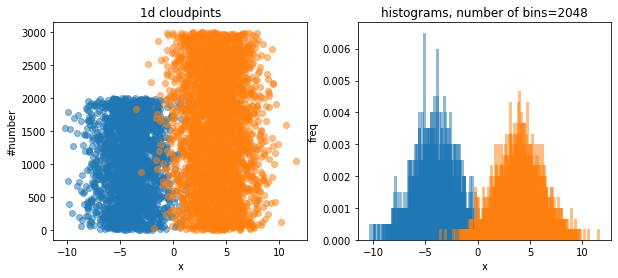

In [566]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('1d cloudpints')
plt.xlabel('x')
plt.ylabel('#number')
plt.scatter(X, range(len(X)), alpha=0.5)
plt.scatter(Y, range(len(Y)), alpha=0.5)
plt.subplot(122)
plt.title(f'histograms, number of bins={n1d}')
plt.xlabel('x')
plt.ylabel('freq')
plt.bar(bins.ravel(), p, width=0.3, alpha=0.5, label='p')
plt.bar(bins.ravel(), q, width=0.3, alpha=0.5, label='q')
plt.show()

In [567]:
p.shape, q.shape, c.shape

((2048,), (2048,), (2048, 2048))

In [568]:
p, q, bins

(array([0.0005, 0.    , 0.    , ..., 0.    , 0.    , 0.    ]),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00033333]),
 array([[-10.21940573],
        [-10.20877774],
        [-10.19814974],
        ...,
        [ 11.51484004],
        [ 11.52546803],
        [ 11.53609602]]))

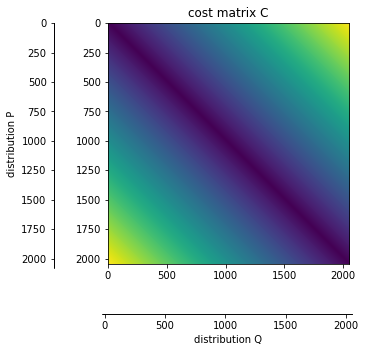

In [569]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.imshow(c)

# histogram on the attached axes
x_hist.imshow(q.reshape(1,-1))
y_hist.imshow(p.reshape(-1,1))
# y_hist.invert_yaxis()

main_ax.set_title('cost matrix C')
y_hist.set_ylabel('distribution P')
x_hist.set_xlabel('distribution Q')

plt.show()

#iterations=57, early stopping: tol, err=1.0374134869713655e-16


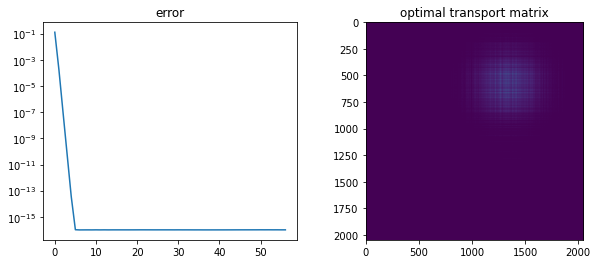

In [570]:
g, K, u, v = sinkhorn(p, q, c, 1, eps=1e-20, max_iter=2000, tol=1e-17, patience=50)

In [571]:
save = dict(p=p, q=q, bins=bins, K=K, u=u, v=v, c=c)

## another one 1d

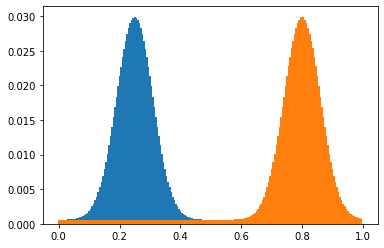

In [511]:
N = 200

t = np.arange(0,N)/N

Gaussian = lambda t0,sigma: np.exp(-(t-t0)**2/(2*sigma**2))
normalize = lambda p: p/np.sum(p)

sigma = .06;
a = Gaussian(.25,sigma)
b = Gaussian(.8,sigma)
vmin = .02;
a = normalize( a+np.max(a)*vmin)
b = normalize( b+np.max(b)*vmin)
plt.bar(t, a, width = 1/len(t))
plt.bar(t, b, width = 1/len(t))
plt.show()

Error=5.352991209463115e-10


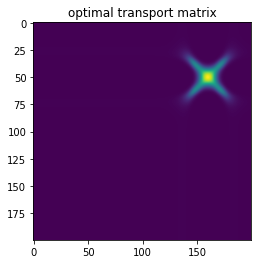

In [512]:
import ot
M = ot.dist(a.reshape(-1,1), b.reshape(-1,1))
# M = M /  M.max()
gamma = ot.sinkhorn(a, b, M, 5e-5)
print(f'Error={np.linalg.norm(gamma.sum(0) - b) + np.linalg.norm(gamma.sum(1) - a)}')
plt.imshow(gamma)
plt.title('optimal transport matrix')
plt.show()

#iterations=219, early stopping: tol, err=3.6496694522269297e-16


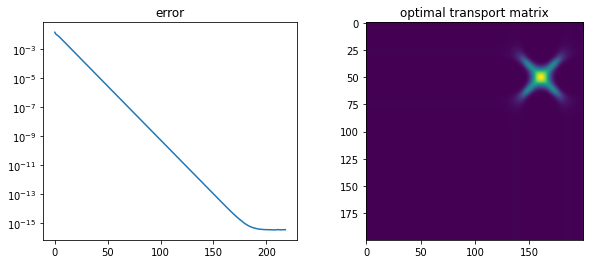

In [513]:
g, K, u, v = sinkhorn(a, b, M, 5e-5, eps=1e-20, max_iter=1000, tol=1e-15, patience=50)

# 2D bins

In [514]:
N, M, d = 200, 150, 2
X = np.random.normal(0, 3, (N, d))
Y = np.random.normal(10, 3, (M, d))

n2d = 8

In [515]:
clouds = np.vstack([X, Y])

bins1 = centers(binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=(n2d, n2d)).bin_edges[0])
bins2 = centers(binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=(n2d, n2d)).bin_edges[1])
[x, y] = np.meshgrid(bins2, bins1, indexing='xy')
bins = np.hstack([x.reshape(-1,1), y[::-1].reshape(-1,1)])

c = cdist(bins, bins)
c2d = c

binsX = binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=(n2d, n2d), expand_binnumbers=True).binnumber[:,:len(X)] - 1
binsY = binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=(n2d, n2d), expand_binnumbers=True).binnumber[:,-len(Y):] - 1

idbX, cX = np.unique(binsX.T, return_counts=True, axis=0)
idbY, cY = np.unique(binsY.T, return_counts=True, axis=0)

In [516]:
p = np.zeros((n2d, n2d))
p[idbX[:,0], idbX[:,1]] = cX
p /= p.sum()

q = np.zeros((n2d, n2d))
q[idbY[:,0], idbY[:,1]] = cY
q /= q.sum()

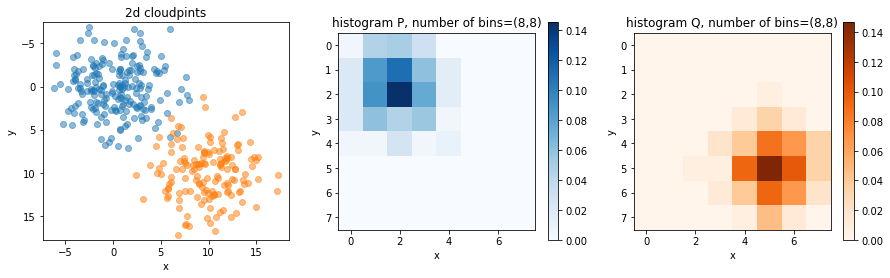

In [517]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('2d cloudpints')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.scatter(Y[:,0], Y[:,1], alpha=0.5)
plt.ylim(max(X.max(), Y.max()) + 0.5, min(X.min(), Y.min()) - 0.5)
plt.subplot(132)
plt.title(f'histogram P, number of bins=({n2d},{n2d})')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(p, cmap='Blues')
plt.colorbar()
plt.subplot(133)
plt.title(f'histogram Q, number of bins=({n2d},{n2d})')
plt.xlabel('x')
plt.ylabel('y')
plt.imshow(q, cmap='Oranges')
plt.colorbar()
plt.show()

#iterations=18, early stopping: tol, err=1.204805786892093e-16


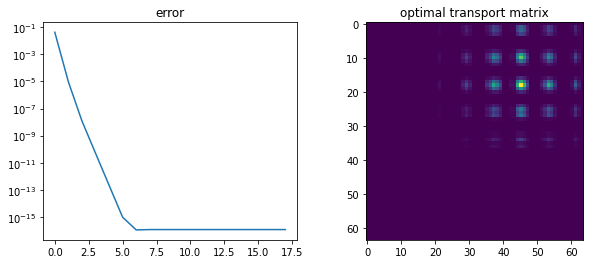

In [518]:
g, K, u, v = sinkhorn(p.ravel(), q.ravel(), c, 10, eps=1e-20, max_iter=1000, tol=1e-17, patience=10)

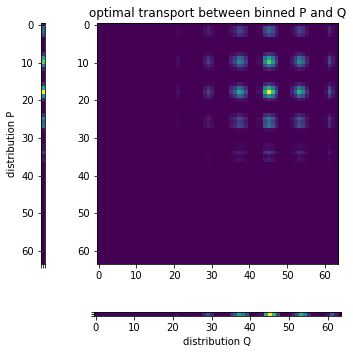

In [519]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.imshow(g)

# histogram on the attached axes
x_hist.imshow(q.reshape(1,-1))
x_hist.invert_yaxis()

y_hist.imshow(p.reshape(-1,1))
y_hist.invert_xaxis()

main_ax.set_title('optimal transport between binned P and Q')
y_hist.set_ylabel('distribution P')
x_hist.set_xlabel('distribution Q')

plt.show()

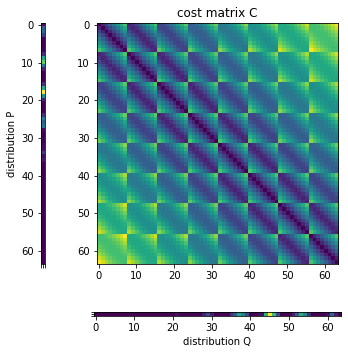

In [520]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.imshow(c)

# histogram on the attached axes
x_hist.imshow(q.reshape(1,-1))
x_hist.invert_yaxis()

y_hist.imshow(p.reshape(-1,1))
y_hist.invert_xaxis()

main_ax.set_title('cost matrix C')
y_hist.set_ylabel('distribution P')
x_hist.set_xlabel('distribution Q')

plt.show()

# 3D bins

In [521]:
N, M, d = 200, 150, 3
X = np.random.normal(0, 3, (N, d))
Y = np.random.normal(10, 3, (M, d))

n3d = 4

In [522]:
clouds = np.vstack([X, Y])

bins1 = centers(binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=(n3d, n3d, n3d)).bin_edges[0])
bins2 = centers(binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=(n3d, n3d, n3d)).bin_edges[1])
bins3 = centers(binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=(n3d, n3d, n3d)).bin_edges[2])
[x, y, z] = np.meshgrid(bins1, bins2, bins3, indexing='xy')
bins = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])

c = cdist(bins, bins)
c3d = c

binsX = binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=(n3d, n3d, n3d), expand_binnumbers=True).binnumber[:,:len(X)] - 1
binsY = binned_statistic_dd(clouds, np.zeros_like(clouds), statistic='count', bins=(n3d, n3d, n3d), expand_binnumbers=True).binnumber[:,-len(Y):] - 1

idbX, cX = np.unique(binsX.T, return_counts=True, axis=0)
idbY, cY = np.unique(binsY.T, return_counts=True, axis=0)

In [523]:
p = np.zeros((n3d, n3d, n3d))
p[idbX[:,0], idbX[:,1], idbX[:,2]] = cX
p /= p.sum()

q = np.zeros((n3d, n3d, n3d))
q[idbY[:,0], idbY[:,1], idbY[:,2]] = cY
q /= q.sum()

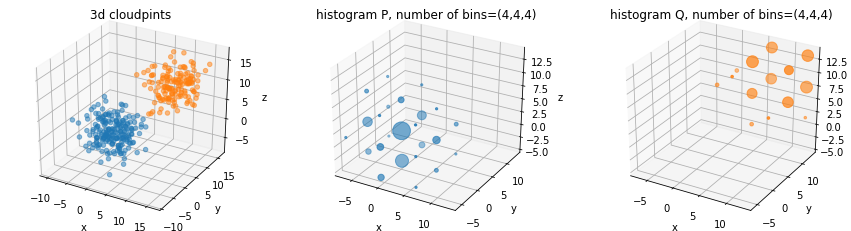

In [524]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(131, projection='3d')
ax.set_title('3d cloudpints')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(X[:,0], X[:,1], X[:,2], alpha=0.5)
ax.scatter(Y[:,0], Y[:,1], Y[:,2], alpha=0.5)
ax2 = fig.add_subplot(132, projection='3d')
ax2.set_title(f'histogram P, number of bins=({n3d},{n3d},{n3d})')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.scatter(bins[:,0], bins[:,1], bins[:,2], s=p.ravel() * 1000, marker='o', c='#1f77b4')
ax3 = fig.add_subplot(133, projection='3d')
ax3.set_title(f'histogram Q, number of bins=({n3d},{n3d},{n3d})')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.scatter(bins[:,0], bins[:,1], bins[:,2], s=q.ravel() * 1000, marker='o', c='#ff7f0e')
plt.show()

#iterations=19, early stopping: tol, err=1.1591478574927823e-16


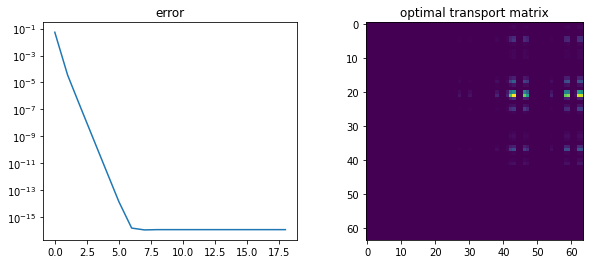

In [525]:
g, K, u, v = sinkhorn(p.ravel(), q.ravel(), c, 10, eps=1e-20, max_iter=1000, tol=1e-17, patience=10)

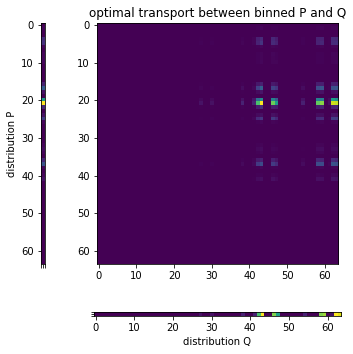

In [526]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.imshow(g)

# histogram on the attached axes
x_hist.imshow(q.reshape(1,-1))
x_hist.invert_yaxis()

y_hist.imshow(p.reshape(-1,1))
y_hist.invert_xaxis()

main_ax.set_title('optimal transport between binned P and Q')
y_hist.set_ylabel('distribution P')
x_hist.set_xlabel('distribution Q')

plt.show()

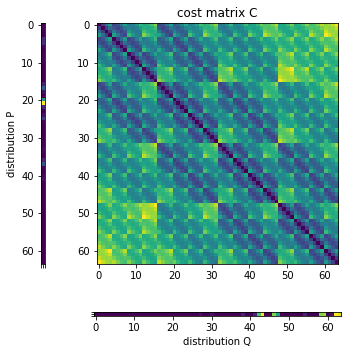

In [527]:
# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.imshow(c)

# histogram on the attached axes
x_hist.imshow(q.reshape(1,-1))
x_hist.invert_yaxis()

y_hist.imshow(p.reshape(-1,1))
y_hist.invert_xaxis()

main_ax.set_title('cost matrix C')
y_hist.set_ylabel('distribution P')
x_hist.set_xlabel('distribution Q')

plt.show()

# toeplitz 1d matvec

In [528]:
blocks = c1d[0].reshape(n1d)
blocks1d = blocks
blocks

array([0.00000000e+00, 2.11249460e-02, 4.22498920e-02, ...,
       2.15685699e+01, 2.15896948e+01, 2.16108198e+01])

In [529]:
circ = np.concatenate([blocks, np.zeros(1), blocks[:0:-1]], -1)

In [530]:
circ.shape, c1d.shape

((2048,), (1024, 1024))

In [531]:
x1d = np.random.rand(1024)
x_ = np.pad(x1d, (0, n1d))

In [532]:
np.abs(mkl_fft.ifftn((mkl_fft.fftn(circ) * mkl_fft.fftn(x_))))[:n1d].ravel()

array([5524.81999818, 5513.98729718, 5503.16777486, ..., 5568.78662908,
       5579.59864177, 5590.44657052])

In [533]:
c1d.dot(x1d)

array([5524.81999818, 5513.98729718, 5503.16777486, ..., 5568.78662908,
       5579.59864177, 5590.44657052])

# toeplitz 2d matvec

In [534]:
blocks = c2d[0].reshape(n2d, n2d)
blocks2d = blocks
blocks

array([[ 0.        ,  3.01925572,  6.03851145,  9.05776717, 12.07702289,
        15.09627862, 18.11553434, 21.13479006],
       [ 2.93051391,  4.20759039,  6.71204382,  9.52003455, 12.42748542,
        15.37808635, 18.35103529, 21.33699282],
       [ 5.86102782,  6.59299266,  8.41518078, 10.78864186, 13.42408765,
        16.19411236, 19.04006911, 21.93241888],
       [ 8.79154174,  9.29554255, 10.66559077, 12.62277118, 14.93806172,
        17.46965467, 20.13613147, 22.89040317],
       [11.72205565, 12.10464761, 13.18598533, 14.81383592, 16.83036157,
        19.11293323, 21.57728373, 24.16786998],
       [14.65256956, 14.9604044 , 15.84807292, 17.22617023, 18.98821415,
        21.03795196, 23.29957895, 25.71725385],
       [17.58308347, 17.84042403, 18.59108509, 19.77897799, 21.33118155,
        23.17460792, 25.24554235, 27.49262038],
       [20.51359738, 20.73459869, 21.38390278, 22.42433552, 23.80466676,
        25.46969387, 27.36750376, 29.45313275]])

In [535]:
block_circ = np.concatenate([blocks,     np.zeros((n2d, 1)),     blocks[:,:0:-1]],   -1)
circ       = np.concatenate([block_circ, np.zeros((1, n2d * 2)), block_circ[:0:-1]], -2)

In [536]:
circ.shape, c2d.shape

((16, 16), (64, 64))

In [537]:
x2d = np.random.rand(64)
x_ = np.pad(x2d.reshape(n2d,n2d), ((0,n2d),(0,n2d)))

In [538]:
c2d.dot(x2d)

array([522.54023078, 468.76719903, 431.81963437, 413.74480717,
       415.19559617, 436.07280733, 472.37853321, 523.11709069,
       474.97966227, 416.16065202, 376.97969008, 359.98477129,
       360.89164618, 381.60799745, 418.566601  , 472.53107123,
       443.52505784, 382.80658959, 342.07567776, 324.74077189,
       325.1119547 , 343.35828915, 382.56692203, 438.60592989,
       428.89344782, 368.09906799, 327.54931944, 308.37521175,
       307.59732338, 324.96416788, 362.62216134, 419.85992702,
       430.74175637, 369.51871032, 328.66484891, 309.51928768,
       307.65822614, 324.70586467, 362.12845351, 419.62804627,
       449.83558114, 391.28911206, 350.31567304, 328.55972389,
       325.92265068, 342.79287291, 380.88392821, 437.61656903,
       483.90063906, 427.86919738, 389.00702612, 365.86963491,
       361.87095717, 379.25062023, 414.8526188 , 470.46424766,
       535.67385776, 482.72828324, 445.29265323, 423.04395142,
       418.73434651, 433.24694028, 467.66832998, 520.93

In [539]:
np.abs(mkl_fft.ifftn((mkl_fft.fftn(circ) * mkl_fft.fftn(x_))))[:n2d,:n2d].ravel()

array([522.54023078, 468.76719903, 431.81963437, 413.74480717,
       415.19559617, 436.07280733, 472.37853321, 523.11709069,
       474.97966227, 416.16065202, 376.97969008, 359.98477129,
       360.89164618, 381.60799745, 418.566601  , 472.53107123,
       443.52505784, 382.80658959, 342.07567776, 324.74077189,
       325.1119547 , 343.35828915, 382.56692203, 438.60592989,
       428.89344782, 368.09906799, 327.54931944, 308.37521175,
       307.59732338, 324.96416788, 362.62216134, 419.85992702,
       430.74175637, 369.51871032, 328.66484891, 309.51928768,
       307.65822614, 324.70586467, 362.12845351, 419.62804627,
       449.83558114, 391.28911206, 350.31567304, 328.55972389,
       325.92265068, 342.79287291, 380.88392821, 437.61656903,
       483.90063906, 427.86919738, 389.00702612, 365.86963491,
       361.87095717, 379.25062023, 414.8526188 , 470.46424766,
       535.67385776, 482.72828324, 445.29265323, 423.04395142,
       418.73434651, 433.24694028, 467.66832998, 520.93

# toeplitz 3d matvec

In [540]:
blocks = c3d[0].reshape(n3d, n3d, n3d)
blocks3d = blocks
blocks

array([[[ 0.        ,  5.90289384, 11.80578767, 17.70868151],
        [ 6.59295212,  8.84936005, 13.5219688 , 18.89614825],
        [13.18590425, 14.44687601, 17.69872011, 22.07862024],
        [19.77885637, 20.64091362, 23.03431748, 26.54808016]],

       [[ 6.27587349,  8.61572653, 13.370236  , 18.78786813],
        [ 9.1023956 , 10.84885991, 14.90738838, 19.91107748],
        [14.60324138, 15.7511528 , 18.77847921, 22.95325815],
        [20.75065655, 21.57391719, 23.87396846, 27.27979377]],

       [[12.55174697, 13.87049054, 17.23145306, 21.70584605],
        [14.17791839, 15.35765364, 18.44966104, 22.68503407],
        [18.20479121, 19.13788333, 21.69771982, 25.39708298],
        [23.42540312, 24.15768339, 26.23215839, 29.36574386]],

       [[18.82762046, 19.73128095, 22.22286918, 25.8471796 ],
        [19.94859168, 20.80361665, 23.18022719, 26.67477668],
        [22.98580786, 23.73165647, 25.84035576, 29.01628446],
        [27.30718681, 27.93790628, 29.74994242, 32.54657973]]])

In [541]:
row_blocks = np.concatenate([blocks,     np.zeros((n3d, n3d, 1)),         blocks[:,:,:0:-1]],  -1)
block_circ = np.concatenate([row_blocks, np.zeros((n3d, 1, n3d * 2)),     row_blocks[:,:0:-1]], -2)
circ       = np.concatenate([block_circ, np.zeros((1, n3d * 2, n3d * 2)), block_circ[:0:-1]],   -3)

In [542]:
circ.shape, c3d.shape

((8, 8, 8), (64, 64))

In [543]:
x3d = np.random.rand(64)
x_ = np.pad(x3d.reshape(n3d,n3d,n3d), ((0,n3d),(0,n3d),(0,n3d)))

In [544]:
c3d.dot(x3d) 

array([584.35848571, 527.44060978, 526.02754113, 578.6400409 ,
       516.14213249, 454.43260765, 452.12517513, 510.70630076,
       508.71990906, 449.54882722, 449.40366046, 505.75955741,
       564.0825428 , 511.3670444 , 512.10455469, 569.17676339,
       521.43626272, 461.50816482, 461.08408153, 517.61683342,
       445.2807386 , 382.08452144, 380.61188597, 441.5307096 ,
       435.67093236, 374.04888006, 375.03875768, 436.74083191,
       498.76857087, 441.69665965, 446.6795561 , 506.05840556,
       513.8053373 , 455.71095519, 450.73664294, 508.58166823,
       439.96425162, 373.32423375, 370.89048273, 434.28935649,
       430.55176345, 366.68429376, 368.16636807, 431.5171449 ,
       497.2696526 , 437.70747069, 439.87469412, 500.15664054,
       569.47026368, 511.2244575 , 505.91402951, 559.25290416,
       498.31951988, 437.97077819, 432.43425725, 493.04444991,
       494.81955502, 431.24399465, 432.27745827, 494.24063115,
       557.7104357 , 500.60642391, 501.77631322, 557.31

In [545]:
np.abs(mkl_fft.ifftn(mkl_fft.fftn(circ) * mkl_fft.fftn(x_)))[:n3d,:n3d,:n3d].ravel()

array([584.35848571, 527.44060978, 526.02754113, 578.6400409 ,
       516.14213249, 454.43260765, 452.12517513, 510.70630076,
       508.71990906, 449.54882722, 449.40366046, 505.75955741,
       564.0825428 , 511.3670444 , 512.10455469, 569.17676339,
       521.43626272, 461.50816482, 461.08408153, 517.61683342,
       445.2807386 , 382.08452144, 380.61188597, 441.5307096 ,
       435.67093236, 374.04888006, 375.03875768, 436.74083191,
       498.76857087, 441.69665965, 446.6795561 , 506.05840556,
       513.8053373 , 455.71095519, 450.73664294, 508.58166823,
       439.96425162, 373.32423375, 370.89048273, 434.28935649,
       430.55176345, 366.68429376, 368.16636807, 431.5171449 ,
       497.2696526 , 437.70747069, 439.87469412, 500.15664054,
       569.47026368, 511.2244575 , 505.91402951, 559.25290416,
       498.31951988, 437.97077819, 432.43425725, 493.04444991,
       494.81955502, 431.24399465, 432.27745827, 494.24063115,
       557.7104357 , 500.60642391, 501.77631322, 557.31

In [546]:
for b in blocks:
    for bb in blocks:
        t = sp.linalg.toeplitz(bb)

## Matvec Toeplitz

In [547]:
is_pow_2 = lambda x: x == 2 ** int(np.log2(x))

class Toeplitz(object):
    '''Class for utilizing Toeplitz matrix (assume it is symmetric and has block-level no more than 3)'''
    def __init__(self, top, size=None):
        '''
        
        top: nd.array, 
                the first row of the matrix, that defines the matrix; if 'size' is None, then assume that 
                shape of the array defines the block-level structure.
        size: tuple of int or None, 
                defines block-level structure, i.e. number of dimensions equals to level of matrix,
                each size of dimension is number of blocks of each level and size of last dimension is block size.
                Any size needs to be a power of 2.
        '''
        self.top = top if size is None else top.reshape(size)
        self.size = top.shape if size is None else size
        self.dim = len(self.size)
        self.area = tuple(slice(s) for s in self.size)
        self.pad = tuple((0, s) for s in self.size)
        
        assert all([is_pow_2(s) for s in self.size]), 'sizes need to be powers of 2'
        
        self.embedding = self.make_embedding(self.top)
        self.circ_fft = mkl_fft.fftn(self.embedding)
    
    def make_embedding(self, top):
        blocks = top
        for i in range(-1, -self.dim - 1, -1):
            zeros_size = list(self.size)
            for j in range(i, 0):
                if j == i:
                    zeros_size[j] = 1
                else:
                    zeros_size[j] *= 2
            slice_ = [slice(None) for _ in range(self.dim)]
            slice_[i] = slice(None, 0, -1)
            blocks = np.concatenate([blocks, np.zeros(zeros_size), blocks[tuple(slice_)]], i)
        return blocks
        
    def matvec(self, x):
        ''' fast "matvec" multiplication '''
        if x.ndim > 1:
            if (x.shape[0] == 1 or x.shape[1] == 1):
                x = x.ravel()
            else:
                raise ValueError()
        x_fft = mkl_fft.fftn(np.pad(x.reshape(self.size), self.pad))
        
        return np.abs(mkl_fft.ifftn(self.circ_fft * x_fft)[self.area]).ravel()
    
    def full(self):
        ''' return full matrix np.exp(-C / beta)'''
        raise NotImplementedError()
#         return sp.linalg.toeplitz(self.embedding[:self.x_size], np.hstack([[0], self.fembedding[:self.x_size:-1]]))

In [548]:
tb_1d = Toeplitz(blocks1d)
np.isclose(tb_1d.matvec(x1d), c1d.dot(x1d)).all()

True

In [549]:
tb_2d = Toeplitz(blocks2d)
np.isclose(tb_2d.matvec(x2d), c2d.dot(x2d)).all()

True

In [551]:
tb_3d = Toeplitz(blocks3d)
np.isclose(tb_3d.matvec(x3d), c3d.dot(x3d)).all()

True

# Sinkhorn + toeplitz matvec

In [572]:
def sinkhorn_toeplitz(p, q, bins, beta=0.01, eps=1e-12, max_iter=200, tol=1e-10, patience=10, plot=True):
    '''
    p, q - distributions
    bins - coordinates of bins centers
    beta - regularization parameter 
    '''
    size = p.shape
    
    C = cdist(bins, bins)
    top = cdist(bins[0].reshape(1,-1), bins) # C[0]
    K = Toeplitz(np.exp(- top / beta), size)
    Kt = K
    K_ = np.exp(- C / beta)
    b = np.ones(size)
    err = [10]
    i = 0
    j = 0
    while i < max_iter:
        a = np.divide(p, K.matvec(b))
        b = np.divide(q, Kt.matvec(a))
        ######################################################### not optimized - TODO
        g = a.reshape(-1, 1) * K_ * b.reshape(1, -1)
        
        err.append(np.linalg.norm(g.sum(0) - q) + np.linalg.norm(g.sum(1) - p))
        #########################################################
        # if good enough
        if err[-1] < eps:
            print(f'#iterations={i+1}, early stopping: eps, err={err[-1]}')
            break
        # if no improvements
        if np.abs(err[-2] - err[-1]) < tol:
            j += 1
            if j > patience:
                print(f'#iterations={i+1}, early stopping: tol, err={err[-1]}')
                break
        else:
            j = 0
        i +=1
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title('error')
        plt.semilogy(range(len(err)-1), err[1:])
        plt.subplot(122)
        plt.title('optimal transport matrix')
        plt.imshow(g)
        plt.show()
    
    return g, K_, a, b

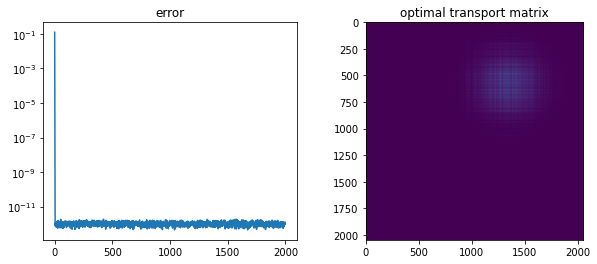

In [573]:
g, K, u, v = sinkhorn_toeplitz(save['p'], save['q'], save['bins'], 1, eps=1e-20, max_iter=2000, tol=1e-17, patience=50)

In [574]:
np.mean(u - save['u']), np.mean(v - save['v'])

(-3.109995072432542e-13, 1.0784645513050494e-06)

In [575]:
%timeit sinkhorn_toeplitz(save['p'], save['q'], save['bins'], 1, eps=1e-100, max_iter=1000, tol=1e-100, patience=50, plot=False)

1 loop, best of 3: 1min 13s per loop


In [576]:
%timeit sinkhorn(save['p'], save['q'], save['bins'].ravel(), 1, eps=1e-100, max_iter=1000, tol=1e-100, patience=1000, plot=False)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


1 loop, best of 3: 1min 4s per loop


# hm :(

In [595]:
##############################################################################################################################

# TODO 

- [barycentric mapping](https://papers.nips.cc/paper/6312-mapping-estimation-for-discrete-optimal-transport.pdf)

- optimize code (g and etc.)

- tests

Once the probabilistic coupling $\gamma_0$ has been computed, one needs to map
the examples from $\Omega_{S}$ to $\Omega_{T}$. This mapping can be conveniently expressed with respect to the set of
examples $X_t$ as the following barycentric mapping:
$$\hat{x_i^s} = \arg\min_{x\in\Omega_{T}} \sum_{j=0}^{n_t} \gamma_0(i, j) c(x, x^t_j),$$
where $x^s_i$ is a given source sample and $\hat{x^s_i}$ is its corresponding image. When the cost function is the
squared $\ell_2$ distance, i.e. $c(x, x_0) = \|x − x_0\|_2^2$, this barycentre corresponds to a weighted average
and the sample is mapped into the convex hull of the target examples. For all source samples, this
barycentric mapping can therefore be expressed as:
$$X_S = B_{\gamma_0}(X_S) = diag(\gamma_0 1_{n_t})^{-1} \gamma_0 X_T.$$

In [583]:
# def mapping(gamma, X):
#     '''
#     gamma - optimal transport
#     X - set of source samples to map (bins)
#     '''
#     return np.linalg.pinv(np.diag(gamma.sum(1))) @ gamma @ X

### Time comparison

In [159]:
results = []
for i in tqdm(range(5, 15)):
    N = 2 ** i
    X = np.random.rand(N, N) # matrix K
    x = np.random.rand(2 * N) # matrix K as vector
    y = np.random.rand(2 * N) # u (512) padded with zeros to (1024)
    fftx = np.fft.fft(x)
    
    tr = %timeit -q -o np.fft.ifft(fftx * np.fft.fft(y))
    results.append(tr.best)
    tr = %timeit -q -o sp.fft.ifft(fftx * sp.fft.fft(y))
    results.append(tr.best)
    tr = %timeit -q -o fftpack.ifft(fftx * fftpack.fft(y))
    results.append(tr.best)
    tr = %timeit -q -o mkl_fft.ifft(fftx * mkl_fft.fft(y))
    results.append(tr.best)
    
    tr = %timeit -q -o X.dot(y[:N])
    results.append(tr.best)

100%|██████████| 10/10 [02:57<00:00, 17.77s/it]


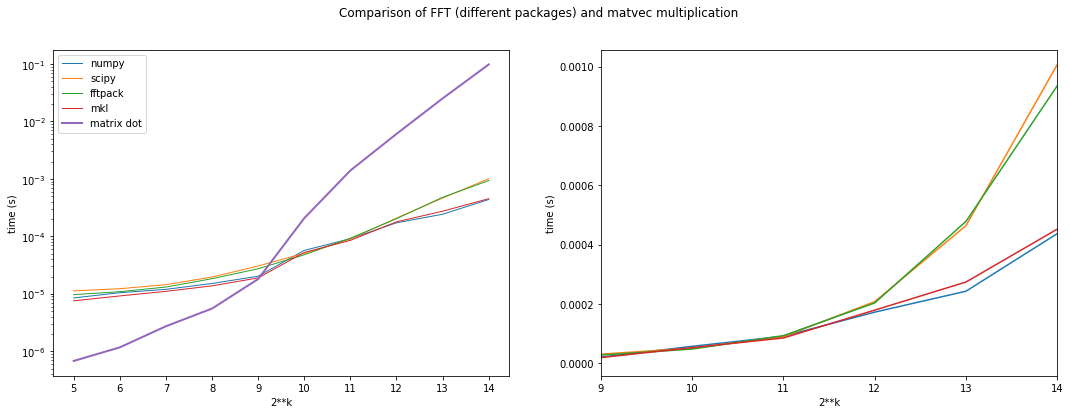

In [160]:
plt.figure(figsize=(18,6))
plt.suptitle('Comparison of FFT (different packages) and matvec multiplication')
plt.subplot(121)
plt.xlabel('2**k')
plt.ylabel('time (s)')
plt.xticks(range(10), range(5, 15))
plt.semilogy(results[0::5], linewidth=1, label='numpy')
plt.semilogy(results[1::5], linewidth=1, label='scipy')
plt.semilogy(results[2::5], linewidth=1, label='fftpack')
plt.semilogy(results[3::5], linewidth=1, label='mkl')
plt.semilogy(results[4::5], linewidth=2, label='matrix dot')
plt.legend()

plt.subplot(122)
plt.xlabel('2**k')
plt.ylabel('time (s)')
plt.xticks(range(10), range(5, 15))
plt.xlim(4, 9)
plt.plot(results[0::5])
plt.plot(results[1::5])
plt.plot(results[2::5])
plt.plot(results[3::5])
plt.show()